# Analyse des lieux de naissance des intellectuels

Question : Comment les naissances des intellectuels sont-elles distribuées dans l'espace ?

## Importation des librairies

In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

import math

In [3]:
### Instructions pour l'installation dans JupyterLab : 
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
# Utiliser idéalement JupyterLab 3.0

from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple,
    SelectionRangeSlider, Layout,
    jslink, fixed,
    HTML, HBox)

In [4]:
from ipyleaflet import (Map,
                        Marker,
                        basemap_to_tiles,
                        basemaps,
                        CircleMarker,
                        MarkerCluster,
                        LayerGroup, 
                        LayersControl,
                        WidgetControl,
                        Popup,
                        ScaleControl
                       )

In [5]:
import sparql_functions as spqf

In [6]:
reload(spqf)

<module 'sparql_functions' from 'C:\\jupyter_notebooks\\JS_intellectuels\\sparql_functions.py'>

In [7]:
# Adresse des fichiers de la base de données 
db = 'data/intellectuels.db'

# Explorer et coder les lieux de naissance

## Requêtes préliminaires

In [8]:
# Adresse des fichiers de la base de données 
db = 'data/intellectuels.db'

In [9]:
### Vérifier si tous les lieux on un type
query_1 ="""
SELECT e.uri_entity, p.value 
FROM entity e LEFT JOIN property p ON p.uri_entity = e.uri_entity 
WHERE e.entity_class = 'https://dbpedia.org/ontology/Place';
"""

In [10]:
### Combien de personnnes ont / n'ont pas un lieu de naissance renseigné
query_2 ="""
WITH TW1 AS (
SELECT DISTINCT  e.uri_entity 
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND property LIKE '%BirthPlace%'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Person'
AND p.value IS NOT NULL --IS NULL;
)
SELECT COUNT (*)
FROM tw1;
"""

In [11]:
### Liste des lieux avec types et coordonnées géographiques
lieux = """SELECT e.uri_entity, 
REPLACE(REPLACE(e.uri_entity, 'http://dbpedia.org/resource/', ''), '_', ' ') place_name, 
REPLACE(REPLACE(p.value, 'http://dbpedia.org/ontology/', ''), '_', ' ') place_type,
p1.value longitude, p2.value latitude
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND p.property LIKE '%type%'
  LEFT JOIN property p1 ON p1.uri_entity = e.uri_entity AND p1.property LIKE '%long'
  LEFT JOIN property p2 ON p2.uri_entity = e.uri_entity AND p2.property LIKE '%lat'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Place'
--AND p.value IS NOT NULL   -- si décommmenté, élimine les lieux sans type
;"""

In [12]:
### Liste complete: personne, lieu, type, coordonnées géo
personnes_lieux_naissance = """
SELECT e.uri_entity, 
p4.value birth_year,
 REPLACE(REPLACE(p.value, 'http://dbpedia.org/resource/', ''), '_', ' ') place_name, 
REPLACE(p3.value, 'http://dbpedia.org/ontology/', '') place_type, 
p1.value longitude, p2.value latitude
FROM entity e 
  LEFT JOIN property p ON p.uri_entity = e.uri_entity AND p.property LIKE '%BirthPlace%'
  LEFT JOIN property p1 ON p1.uri_entity = p.value AND p1.property LIKE '%long'
  LEFT JOIN property p2 ON p2.uri_entity = p.value AND p2.property LIKE '%lat'
  LEFT JOIN property p3 ON p3.uri_entity = p.value AND p3.property LIKE '%type%'
  LEFT JOIN property p4 ON p4.uri_entity = e.uri_entity AND p4.property LIKE '%irthYe%'
WHERE e.entity_class = 'https://dbpedia.org/ontology/Person'
AND longitude IS NOT NULL;
"""

In [13]:
# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
# attention au nom de la requête !
c.execute(lieux)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:4]

31516


[('http://dbpedia.org/resource/%5Bhttps://ta.wikipedia.org/wiki/கூத்தூர்_ஊராட்சி_Kuttur',
  '%5Bhttps://ta.wikipedia.org/wiki/கூத்தூர் ஊராட்சி Kuttur',
  None,
  None,
  None),
 ("http://dbpedia.org/resource/'Asir_Region",
  "'Asir Region",
  'AdministrativeRegion',
  None,
  None),
 ("http://dbpedia.org/resource/'Asir_Region",
  "'Asir Region",
  'Region',
  None,
  None),
 ("http://dbpedia.org/resource/'Hickory_Hill',Hague_Virginia",
  "'Hickory Hill',Hague Virginia",
  None,
  None,
  None)]

## Types de lieux 

In [14]:
### Requête 'lieux' !!! 
# transformée en DataFrame
df_lieux = pd.DataFrame(result_q, columns = ['uri', 'name', 'type', 'long', 'lat'])
df_lieux

,uri,name,type,long,lat
0,http://dbpedia.org/resource/%5Bhttps://ta.wiki...,%5Bhttps://ta.wikipedia.org/wiki/கூத்தூர் ஊராட...,None,None,None
1,http://dbpedia.org/resource/'Asir_Region,'Asir Region,AdministrativeRegion,None,None
2,http://dbpedia.org/resource/'Asir_Region,'Asir Region,Region,None,None
3,"http://dbpedia.org/resource/'Hickory_Hill',Hag...","'Hickory Hill',Hague Virginia",None,None,None
4,http://dbpedia.org/resource/'Uyayna,'Uyayna,None,46.3914,24.9053
...,...,...,...,...,...
31511,http://dbpedia.org/resource/Ștefan_Vodă_District,Ștefan Vodă District,Region,29.6667,46.5
31512,"http://dbpedia.org/resource/Ștefănești,_Argeș","Ștefănești, Argeș",Village,24.95,44.8667
31513,http://dbpedia.org/resource/Țăndărei,Țăndărei,None,27.6586,44.6403
31514,http://www.latlong.net/place/adawso-ghana-1082...,http://www.latlong.net/place/adawso-ghana-1082...,None,None,None


In [15]:
### Regrouper par type de lieux et compter
gb_lieux = pd.DataFrame(df_lieux.groupby('type').size())
gb_lieux.columns = ['eff']
gb_lieux.sort_values(by='eff', ascending=False)

,eff
type,
City,6444
Town,3590
AdministrativeRegion,2650
Region,2509
Village,1708
...,...
Insect,1
ReligiousBuilding,1
RoadJunction,1


In [16]:
### Retrouper les types par lieux (plusieurs types pour un lieux) puis compter par groupe
# inspecter les différentes typologies
types_lieux = df_lieux.fillna(value='').groupby(['uri'])['type'].apply(','.join).reset_index()
gb_types_lieux = pd.DataFrame(types_lieux.groupby('type').size())
gb_types_lieux.columns = ['eff']
gb_types_lieux.sort_values(by='eff', ascending=False).head(10)

,eff
type,
,11095
City,6257
Town,3435
"AdministrativeRegion,Region",2185
Village,1523
Country,1314
CityDistrict,586
"AdministrativeRegion,Country,Region",242
AdministrativeRegion,130


In [17]:
### Retrouper les types par lieux (plusieurs types pour un lieux) puis compter par groupe
# inspecter les différentes typologies : laquelle retenir ?
types_lieux = df_lieux.fillna(value='').groupby(['uri'])['type'].apply(','.join).reset_index()
gb_types_lieux = pd.DataFrame(types_lieux.groupby('type').size())
gb_types_lieux.columns = ['eff']
gb_types_lieux.sort_values(by='eff', ascending=False).head(20)

,eff
type,
,11095
City,6257
Town,3435
"AdministrativeRegion,Region",2185
Village,1523
Country,1314
CityDistrict,586
"AdministrativeRegion,Country,Region",242
AdministrativeRegion,130


## Obtenir un lieu par personne

Afin de pouvoir représenter les lieux de naissance sur une carte, avec les effectifs des personnes, il est indispensable de nettoyer préalablement les données et de ne disposer, après nettoyage, que d'un lieu par personne.

L'opération est assez délicate étant donné l'état incohérent des données produites automatiquement à partir de Wikipedia.

In [18]:
# Créer un DataFrame directement à partir d'une requête
cn = sql.connect(db)
lieux_naissance = pd.read_sql_query(personnes_lieux_naissance, cn).fillna(value='')
cn.close()
lieux_naissance.head(10)

,uri_entity,birth_year,place_name,place_type,longitude,latitude
0,http://dbpedia.org/resource/5th_Dalai_Lama,1617,Taktsé Castle,,91.6841,29.0295
1,http://dbpedia.org/resource/5th_Dalai_Lama,1617,Tibet,Country,88.8,31.2
2,http://dbpedia.org/resource/5th_Dalai_Lama,1617,Ü-Tsang,,92.2272,30.8558
3,http://dbpedia.org/resource/9th_Wonder,1975,"Winston-Salem, North Carolina",City,-80.2605,36.1028
4,http://dbpedia.org/resource/A.B.C._Whipple,1918,New York (state),AdministrativeRegion,-75.0,43.0
5,http://dbpedia.org/resource/A.B.C._Whipple,1918,New York (state),Region,-75.0,43.0
6,http://dbpedia.org/resource/A.B.C._Whipple,1918,United States,Country,-100.0,40.0
7,http://dbpedia.org/resource/A.G._Lafley,1947,"Keene, New Hampshire",City,-72.2781,42.9336
8,http://dbpedia.org/resource/A.G._Lafley,1947,"Keene, New Hampshire",City,-72.2781,42.9336
9,http://dbpedia.org/resource/A.J._Han_Vinck,1949,Breda,City,4.78333,51.5833


In [19]:
# Construire une colonne qui contient les lieux sous forme de liste avec leur longitude et latitude
lieux_naissance['place_list'] = lieux_naissance[['place_name','place_type','longitude','latitude']].apply(lambda x: list(x), axis=1)
lieux_naissance.head(10)

,uri_entity,birth_year,place_name,place_type,longitude,latitude,place_list
0,http://dbpedia.org/resource/5th_Dalai_Lama,1617,Taktsé Castle,,91.6841,29.0295,"[Taktsé Castle, , 91.6841, 29.0295]"
1,http://dbpedia.org/resource/5th_Dalai_Lama,1617,Tibet,Country,88.8,31.2,"[Tibet, Country, 88.8, 31.2]"
2,http://dbpedia.org/resource/5th_Dalai_Lama,1617,Ü-Tsang,,92.2272,30.8558,"[Ü-Tsang, , 92.2272, 30.8558]"
3,http://dbpedia.org/resource/9th_Wonder,1975,"Winston-Salem, North Carolina",City,-80.2605,36.1028,"[Winston-Salem, North Carolina, City, -80.2605..."
4,http://dbpedia.org/resource/A.B.C._Whipple,1918,New York (state),AdministrativeRegion,-75.0,43.0,"[New York (state), AdministrativeRegion, -75.0..."
5,http://dbpedia.org/resource/A.B.C._Whipple,1918,New York (state),Region,-75.0,43.0,"[New York (state), Region, -75.0, 43.0]"
6,http://dbpedia.org/resource/A.B.C._Whipple,1918,United States,Country,-100.0,40.0,"[United States, Country, -100.0, 40.0]"
7,http://dbpedia.org/resource/A.G._Lafley,1947,"Keene, New Hampshire",City,-72.2781,42.9336,"[Keene, New Hampshire, City, -72.2781, 42.9336]"
8,http://dbpedia.org/resource/A.G._Lafley,1947,"Keene, New Hampshire",City,-72.2781,42.9336,"[Keene, New Hampshire, City, -72.2781, 42.9336]"
9,http://dbpedia.org/resource/A.J._Han_Vinck,1949,Breda,City,4.78333,51.5833,"[Breda, City, 4.78333, 51.5833]"


In [20]:
# Regrouper les lieux de naissance par personne et produire un nouveau dataframe
l_lieux_naissance = lieux_naissance.groupby(['uri_entity']).agg({'place_list': lambda x: list(x),'birth_year': lambda x: max(x)}).reset_index()
l_lieux_naissance.head()

,uri_entity,place_list,birth_year
0,http://dbpedia.org/resource/5th_Dalai_Lama,"[[Taktsé Castle, , 91.6841, 29.0295], [Tibet, ...",1617
1,http://dbpedia.org/resource/9th_Wonder,"[[Winston-Salem, North Carolina, City, -80.260...",1975
2,http://dbpedia.org/resource/A.B.C._Whipple,"[[New York (state), AdministrativeRegion, -75....",1918
3,http://dbpedia.org/resource/A.G._Lafley,"[[Keene, New Hampshire, City, -72.2781, 42.933...",1947
4,http://dbpedia.org/resource/A.J._Han_Vinck,"[[Breda, City, 4.78333, 51.5833]]",1949


In [21]:
# Eliminer les lieux multiples pour une personne
# Privilégier les villes et autres lieux habités par rapport aux territoires

lieux_naissance_unique = []
for l in l_lieux_naissance.to_records():
    
    i_lieux_naiss = []
    if len(i_lieux_naiss) == 0:
        for i in l[2]:
            if i[1] == 'Village':
                i_lieux_naiss = i
            elif i[1] == 'City':
                i_lieux_naiss = i
            elif i[1] == 'Town':
                i_lieux_naiss = i
            elif i[1] == 'Island':
                i_lieux_naiss = i
    else:
        pass
    if len(i_lieux_naiss) == 0:
        i_lieux_naiss = l[2][0]
    ##  la valeur 2020 est pour les personnes sans date de naissance
    lieux_naissance_unique.append([l[1]] + i_lieux_naiss + [int(l[3]) if str(l[3]) > '' else 2020])


print(len(lieux_naissance_unique))
lieux_naissance_unique[:2]

77563


[['http://dbpedia.org/resource/5th_Dalai_Lama',
  'Taktsé Castle',
  '',
  '91.6841',
  '29.0295',
  1617],
 ['http://dbpedia.org/resource/9th_Wonder',
  'Winston-Salem, North Carolina',
  'City',
  '-80.2605',
  '36.1028',
  1975]]

In [22]:
### Ajouter une colonne avec les noms de personne et limiter aux personnes nées après 1880

df_lnu = pd.DataFrame(lieux_naissance_unique)
print(len(df_lnu))
df_lnu.columns = ['uri_entity','place_name','place_type','long','lat', 'birth_year']
df_lnu['person'] = df_lnu['uri_entity'].apply(lambda x : x.replace('http://dbpedia.org/resource/', '').replace('_',' ')) 
df_lnu = df_lnu[df_lnu['birth_year'] > 1880]
print(len(df_lnu))

77563
64412


In [23]:
### Vérifier s'il y a bien un lieu de naissance par personne
gb_df_lnu = df_lnu.groupby(['uri_entity']).size()
print("Plus d'un lieux : " + str(len(gb_df_lnu[gb_df_lnu > 1])))
print("Aucun lieux : " + str(len(gb_df_lnu[gb_df_lnu == 0])))
print("Personnes avec un lieu de naissance : " + str(len(gb_df_lnu[gb_df_lnu == 1])))
df_lnu.head()

Plus d'un lieux : 0
Aucun lieux : 0
Personnes avec un lieu de naissance : 64412


,uri_entity,place_name,place_type,long,lat,birth_year,person
1,http://dbpedia.org/resource/9th_Wonder,"Winston-Salem, North Carolina",City,-80.2605,36.1028,1975,9th Wonder
2,http://dbpedia.org/resource/A.B.C._Whipple,New York (state),AdministrativeRegion,-75.0,43.0,1918,A.B.C. Whipple
3,http://dbpedia.org/resource/A.G._Lafley,"Keene, New Hampshire",City,-72.2781,42.9336,1947,A.G. Lafley
4,http://dbpedia.org/resource/A.J._Han_Vinck,Breda,City,4.78333,51.5833,1949,A.J. Han Vinck
5,http://dbpedia.org/resource/A.K._Nazmul_Karim,Comilla District,,91.12,23.27,1922,A.K. Nazmul Karim


## Produire les données à projeter sur une carte

### Ajouter des périodes d'activité

Découper les intellectuels contemporains en périodes d'activité

Périodes d'activités: -1900 (avant le 20e siècle), 1901-1945 (la période des guerres mondiales), 1946- (l'époque contemporaine)

On imagine ces bornes pour la période d'activité entre 25 et 75 ans

In [24]:
### Fonction qui effectue le classement

# plusieurs périodes d'activité sont possibles pour une même personne

def periode_activite(birth_year):    
    valeur_periode = []
    if (birth_year + 25) < 1901:
        valeur_periode.append("-1900")        
    # la deuxième clause exclut les personnes qui ne sont vraisemblablement plus actives
    # bien que nées avant la date indiquée
    if (birth_year + 75) > 1900 and (birth_year + 25) < 1946:
        valeur_periode.append("1901-1945")
    if (birth_year + 75) > 1945 and (birth_year + 25) < 2010:
        valeur_periode.append("1946-2010")
    return valeur_periode

In [25]:
periode_activite(1860), periode_activite(1873), periode_activite(1900)

(['-1900', '1901-1945'],
 ['-1900', '1901-1945', '1946-2010'],
 ['1901-1945', '1946-2010'])

In [26]:

### Ajouter les périodes d'activité à l'aide de la fonction : periode_activite

df_lnu['periode_activite'] = df_lnu['birth_year'].apply (lambda x : periode_activite(x) )

In [27]:
### Préparer les données qui seront utilisées dans le popup de la carte
# construire une colonne qui contient (avec séparateur pipe, '|', uri, nom et année de naissance)

df_lnu['concat_person'] = df_lnu['uri_entity'] + '|' + df_lnu['person'] + df_lnu['birth_year'].apply (lambda x : ' (' + str(x) + ')' )

In [28]:
df_lnu.head()

,uri_entity,place_name,place_type,long,lat,birth_year,person,periode_activite,concat_person
1,http://dbpedia.org/resource/9th_Wonder,"Winston-Salem, North Carolina",City,-80.2605,36.1028,1975,9th Wonder,[1946-2010],http://dbpedia.org/resource/9th_Wonder|9th Won...
2,http://dbpedia.org/resource/A.B.C._Whipple,New York (state),AdministrativeRegion,-75.0,43.0,1918,A.B.C. Whipple,"[1901-1945, 1946-2010]",http://dbpedia.org/resource/A.B.C._Whipple|A.B...
3,http://dbpedia.org/resource/A.G._Lafley,"Keene, New Hampshire",City,-72.2781,42.9336,1947,A.G. Lafley,[1946-2010],http://dbpedia.org/resource/A.G._Lafley|A.G. L...
4,http://dbpedia.org/resource/A.J._Han_Vinck,Breda,City,4.78333,51.5833,1949,A.J. Han Vinck,[1946-2010],http://dbpedia.org/resource/A.J._Han_Vinck|A.J...
5,http://dbpedia.org/resource/A.K._Nazmul_Karim,Comilla District,,91.12,23.27,1922,A.K. Nazmul Karim,[1946-2010],http://dbpedia.org/resource/A.K._Nazmul_Karim|...


In [29]:
### Regrouper par lieu
# https://izziswift.com/naming-returned-columns-in-pandas-aggregate-function/
place_count = df_lnu.groupby(['place_name', 'place_type', 'long', 'lat'], as_index=False) \
      .agg(persons = ('concat_person', ','.join), effectif=('person', 'count'),\
       periodes = ('periode_activite', 'sum')).sort_values(by=['place_name'])
print(len(place_count))
place_count[130:135]

14650


,place_name,place_type,long,lat,persons,effectif,periodes
130,"Agios Amvrosios, Kyrenia",Village,33.5817,35.3406,http://dbpedia.org/resource/Panayiotis_Kalorko...,1,[1946-2010]
131,Agira,,14.5167,37.65,http://dbpedia.org/resource/Diodorus_Siculus|D...,1,[]
132,Agnita,,24.6172,45.9731,http://dbpedia.org/resource/Ioan_Gyuri_Pascu|I...,1,[1946-2010]
133,Agona Swedru,Town,-0.702778,5.53056,http://dbpedia.org/resource/Kwaw_Ansah|Kwaw An...,1,[1946-2010]
134,"Agoura Hills, California",City,-118.762,34.1533,http://dbpedia.org/resource/Owen_Marecic|Owen ...,1,[]


In [30]:
### Agrège et compte les périodes 
# NB Une personnes pouvant être dans plusieurs périodes, la somme des effectifs des périodes peut-être plus élevée que celle de l'effectif total
place_count['periodes_agregees'] = place_count['periodes'].apply(lambda x : dict(Counter(x)))

In [31]:
### Un exemples : Londres 
place_count[place_count['place_name'] == 'London']

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
7881,London,City,-0.1275,51.5072,http://dbpedia.org/resource/A._J._Ayer|A. J. A...,1423,"[1901-1945, 1946-2010, 1946-2010, 1946-2010, 1...","{'1901-1945': 206, '1946-2010': 1261}"


In [32]:
place_count[place_count['place_name'] == 'London']['periodes_agregees'].values[0]

{'1901-1945': 206, '1946-2010': 1261}

###  Ecrire les données à cartographier dans un fichier CSV
Le fichier 'maps/intellectuels_lieux_naissances.csv' contiendra les données à cartographier et il ne sera pas nécessaire de refaire chaque fois les manipulations ci-dessus, mais on pourra directement travailler sur les cartes

In [33]:
place_count.to_csv('maps/intellectuels_lieux_naissances.csv', sep=';')

In [34]:
# Importer le CSV et mettre son contenu dans la variable 'place_count' 
# Au cas où on ne souhaite pas répéter toutes les opérations précédentes
place_count = pd.read_csv('maps/intellectuels_lieux_naissances.csv', sep=';', index_col=[0])
place_count.head()

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
0,'s-Graveland,Village,5.12111,52.2442,http://dbpedia.org/resource/Tjalling_Koopmans|...,1,"['1901-1945', '1946-2010']","{'1901-1945': 1, '1946-2010': 1}"
1,'s-Hertogenbosch,City,5.30000,51.6833,http://dbpedia.org/resource/Carola_Schouten|Ca...,3,"['1946-2010', '1946-2010', '1901-1945', '1946-...","{'1946-2010': 3, '1901-1945': 1}"
2,16th arrondissement of Paris,Town,2.27649,48.8636,http://dbpedia.org/resource/Jean-Claude_Collia...,4,"['1946-2010', '1946-2010', '1946-2010', '1901-...","{'1946-2010': 4, '1901-1945': 1}"
3,24 Parganas,NaN,88.00000,22.0000,http://dbpedia.org/resource/Dinesh_Das|Dinesh ...,3,"['1901-1945', '1946-2010', '1901-1945', '1946-...","{'1901-1945': 3, '1946-2010': 3}"
4,7th arrondissement of Paris,Town,2.31278,48.8592,http://dbpedia.org/resource/Bernard_Koopman|Be...,2,"['1901-1945', '1946-2010', '1901-1945', '1946-...","{'1901-1945': 2, '1946-2010': 2}"


# Créer une carte 

## Fonds de carte

In [35]:
# Trois exemples :

#watercolor = basemap_to_tiles(basemaps.Stamen.Watercolor)
#esri_sat = basemap_to_tiles(basemaps.Esri.WorldImagery)
#open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

# Chois du fonds de carte:
open_street_map = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)

## https://ipywidgets.readthedocs.io/en/latest/examples/Widget%20Styling.html
m1 = Map(layers=(open_street_map,), center=(35, 5), layout=Layout(width='100%', height='600px'),\
        zoom_control=False    # , zoom=4, scroll_wheel_zoom= True
       )

zoom_slider = IntSlider(description='Zoom level:', min=0, max=15, value=2)
jslink((zoom_slider, 'value'), (m1, 'zoom'))
widget_control1 = WidgetControl(widget=zoom_slider, position='bottomright')
m1.add_control(widget_control1)

control = LayersControl(name='layCont', position='topright')
m1.add_control(control)

m1.add_control(ScaleControl(position='topleft'))

m1

Map(center=[35, 5], controls=(AttributionControl(options=['position', 'prefix'], position='bottomright'), Widg…

## Ajouter la couche avec les personnes

In [36]:
place_count[130:135]

,place_name,place_type,long,lat,persons,effectif,periodes,periodes_agregees
130,"Agios Amvrosios, Kyrenia",Village,33.581700,35.34060,http://dbpedia.org/resource/Panayiotis_Kalorko...,1,['1946-2010'],{'1946-2010': 1}
131,Agira,NaN,14.516700,37.65000,http://dbpedia.org/resource/Diodorus_Siculus|D...,1,[],{}
132,Agnita,NaN,24.617200,45.97310,http://dbpedia.org/resource/Ioan_Gyuri_Pascu|I...,1,['1946-2010'],{'1946-2010': 1}
133,Agona Swedru,Town,-0.702778,5.53056,http://dbpedia.org/resource/Kwaw_Ansah|Kwaw An...,1,['1946-2010'],{'1946-2010': 1}
134,"Agoura Hills, California",City,-118.762000,34.15330,http://dbpedia.org/resource/Owen_Marecic|Owen ...,1,[],{}


In [37]:
## Parcourir le DataFrame et extraire les valeurs
#  i = index, v = valeur

markers = []
for i,v in place_count.iterrows():
    circle = CircleMarker(location=(v['lat'], v['long']), color="black", name=f"{v['place_name']}", \
                              radius = v['effectif']+2, weight=1)   
    
    markers.append(circle)


print("Markers' number " + str(len(markers)))

### Le MarkerCluster agrège automatiquement les résultats en fonction de l'échelle 
# alors que le LayerGroup affiche toujours tout, indépendamment du facteur de zoom

# lg1 = LayerGroup(name='Birth places ' + name_part, layers=(markers))
lg1 = MarkerCluster(name='Birth places', markers=markers)

m1.add_layer(lg1)

Markers' number 14650


## Enregistrer la carte au format HTML

In [38]:
m1.save('maps/intellectuels_lieux_naissances.html', title='Lieux naissances intellectuels')

La carte interactive ne peut être lue qu'en locale... Voici tout de même une capture d'écran : 

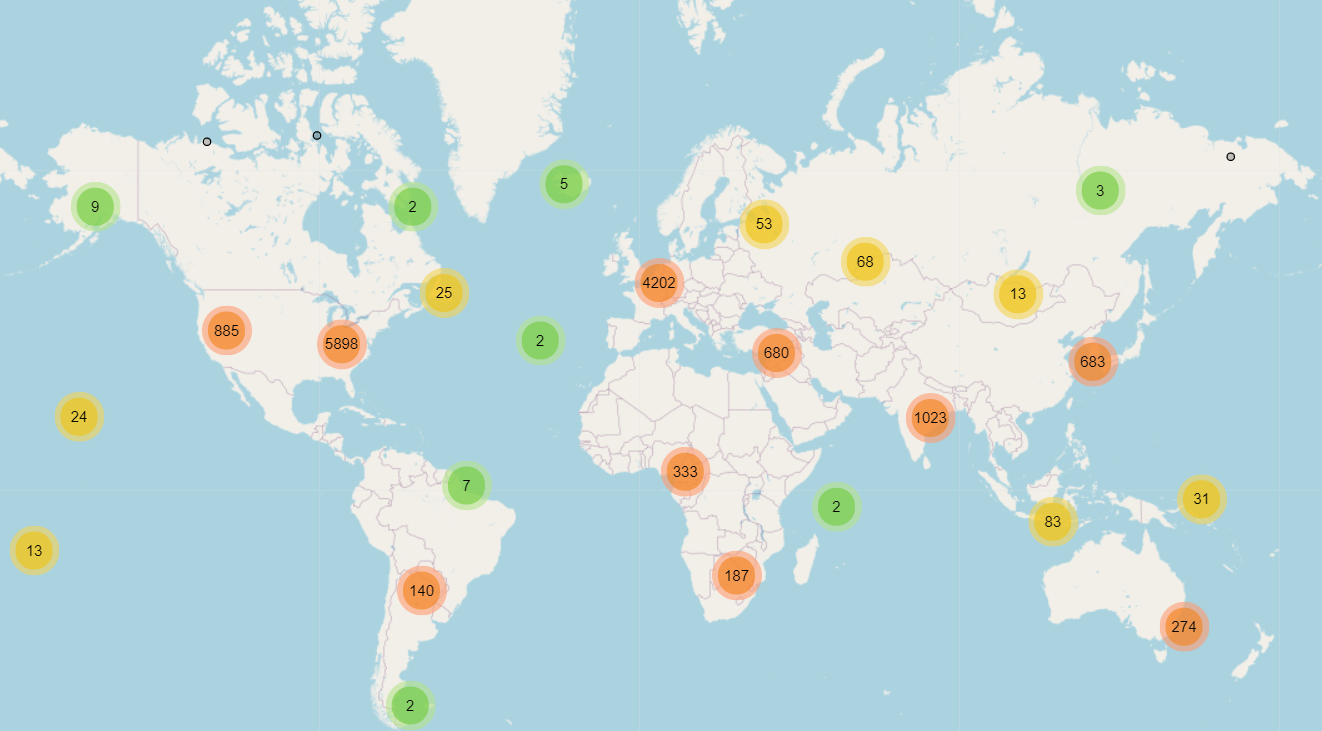